In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

In [ ]:
# Load dataset
file_path = "/content/station_data_dataverse.csv"
df = pd.read_csv(file_path)

In [ ]:
# df.head()

,sessionId,kwhTotal,dollars,created,ended,startTime,endTime,chargeTimeHrs,weekday,platform,...,managerVehicle,facilityType,Mon,Tues,Wed,Thurs,Fri,Sat,Sun,reportedZip
0,1366563,7.78,0.00,2014-11-18 15:40:26,2014-11-18 17:11:04,15,17,1.510556,Tue,android,...,0,3,0,1,0,0,0,0,0,0
1,3075723,9.74,0.00,2014-11-19 17:40:26,2014-11-19 19:51:04,17,19,2.177222,Wed,android,...,0,3,0,0,1,0,0,0,0,0
2,4228788,6.76,0.58,2014-11-21 12:05:46,2014-11-21 16:46:04,12,16,4.671667,Fri,android,...,0,3,0,0,0,0,1,0,0,0
3,3173284,6.17,0.00,2014-12-03 19:16:12,2014-12-03 21:02:18,19,21,1.768333,Wed,android,...,0,3,0,0,1,0,0,0,0,0
4,3266500,0.93,0.00,2014-12-11 20:56:11,2014-12-11 21:14:06,20,21,0.298611,Thu,android,...,0,3,0,0,0,1,0,0,0,0


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
import pickle

# --- Train and Save the Model ---

# Load the data
df = pd.read_csv('/content/station_data_dataverse.csv')  # Replace with your file path
df.columns = df.columns.str.strip()

# Verify required columns
required_cols = ['stationId', 'created', 'ended', 'chargeTimeHrs', 'kwhTotal', 'dollars', 'facilityType']
missing_cols = [col for col in required_cols if col not in df.columns]
if missing_cols:
    print(f"Error: Missing columns {missing_cols}. Available columns: {df.columns.tolist()}")
    exit()

# Fix date format
df['created'] = pd.to_datetime(df['created'].str.replace('0014', '2014').str.replace('0015', '2015'))
df['ended'] = pd.to_datetime(df['ended'].str.replace('0014', '2014').str.replace('0015', '2015'))

# Create a complete time grid for each station
stations = df['stationId'].unique()
time_range = pd.date_range(start=df['created'].min().floor('h'),
                          end=df['ended'].max().ceil('h'),
                          freq='h')
grid = pd.DataFrame([(station, time) for station in stations for time in time_range],
                    columns=['stationId', 'time_bin'])

# Add temporal features to the grid
grid['hour'] = grid['time_bin'].dt.hour.astype(float)
grid['day_of_week'] = grid['time_bin'].dt.dayofweek.astype(float)

# Mark all hours occupied by sessions
occupied = []
for _, row in df.iterrows():
    station = row['stationId']
    start = row['created'].floor('h')
    end = row['ended'].ceil('h')
    times = pd.date_range(start=start, end=end, freq='h')
    for t in times:
        occupied.append((station, t))

occupied_df = pd.DataFrame(occupied, columns=['stationId', 'time_bin'])
occupied_df['isOccupied'] = 1

# Merge with grid
grid = grid.merge(occupied_df, on=['stationId', 'time_bin'], how='left')
grid['isOccupied'] = grid['isOccupied'].fillna(0).astype(int)

# Merge with session data for features
sessions = df.groupby('stationId').agg({
    'chargeTimeHrs': 'mean',
    'kwhTotal': 'mean',
    'dollars': 'mean',
    'facilityType': 'first'
}).reset_index()
grid = grid.merge(sessions, on='stationId', how='left')

# Fill missing values
grid['chargeTimeHrs'] = grid['chargeTimeHrs'].fillna(0)
grid['kwhTotal'] = grid['kwhTotal'].fillna(0)
grid['dollars'] = grid['dollars'].fillna(0)
grid['facilityType'] = grid['facilityType'].fillna(grid['facilityType'].mode()[0])

# Select features and target
features = ['stationId', 'hour', 'day_of_week', 'chargeTimeHrs', 'kwhTotal', 'dollars', 'facilityType']
X = grid[features]
y = grid['isOccupied']

# Encode categorical variables
le = LabelEncoder()
X.loc[:, 'stationId'] = le.fit_transform(X['stationId'])

# Scale numerical features
scaler = StandardScaler()
numerical_cols = ['hour', 'day_of_week', 'chargeTimeHrs', 'kwhTotal', 'dollars']
X.loc[:, numerical_cols] = scaler.fit_transform(X[numerical_cols])

# Balance the dataset with SMOTE
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# Build and train ANN
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# Save the model and preprocessing objects
model.save('ev_charging_model.keras')
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# --- Prediction Function ---

def predict_availability(station_ids, hours, day_of_week, charge_time_hrs, kwh_total, dollars, facility_type):
    # Load saved model and preprocessing objects
    model = tf.keras.models.load_model('ev_charging_model.keras')
    with open('label_encoder.pkl', 'rb') as f:
        le = pickle.load(f)
    with open('scaler.pkl', 'rb') as f:
        scaler = pickle.load(f)

    # Prepare batched input data
    input_data = pd.DataFrame([
        {'stationId': sid, 'hour': float(h), 'day_of_week': float(day_of_week),
         'chargeTimeHrs': charge_time_hrs, 'kwhTotal': kwh_total, 'dollars': dollars,
         'facilityType': facility_type}
        for sid in station_ids for h in hours
    ])

    # Encode stationId
    try:
        input_data.loc[:, 'stationId'] = le.transform(input_data['stationId'])
    except ValueError as e:
        print(f"Error: {e}. Use valid stationIds from {le.classes_}")
        return None

    # Scale numerical features
    numerical_cols = ['hour', 'day_of_week', 'chargeTimeHrs', 'kwhTotal', 'dollars']
    input_data.loc[:, numerical_cols] = scaler.transform(input_data[numerical_cols])

    # Predict in batch
    predictions = model.predict(input_data)
    return predictions.flatten()

# Test multiple scenarios
station_ids = [582873, 549414, 129465]
hours = [8, 12, 18]
day_of_week = 2  # Tuesday
charge_time_hrs = 2.0
kwh_total = 7.0
dollars = 0.5
facility_type = 3

predictions = predict_availability(station_ids, hours, day_of_week, charge_time_hrs, kwh_total, dollars, facility_type)
if predictions is not None:
    for i, (sid, h) in enumerate([(sid, h) for sid in station_ids for h in hours]):
        print(f"Station {sid}, Hour {h}: Predicted Availability: {predictions[i]:.4f}")

Epoch 1/20
31629/31629 ━━━━━━━━━━━━━━━━━━━━ 97s 3ms/step - accuracy: 0.7973 - loss: 0.4336 - val_accuracy: 0.8519 - val_loss: 0.3433
Epoch 2/20
31629/31629 ━━━━━━━━━━━━━━━━━━━━ 98s 3ms/step - accuracy: 0.8511 - loss: 0.3404 - val_accuracy: 0.8577 - val_loss: 0.3251
Epoch 3/20
31629/31629 ━━━━━━━━━━━━━━━━━━━━ 135s 3ms/step - accuracy: 0.8576 - loss: 0.3249 - val_accuracy: 0.8584 - val_loss: 0.3222
Epoch 4/20
31629/31629 ━━━━━━━━━━━━━━━━━━━━ 154s 3ms/step - accuracy: 0.8603 - loss: 0.3191 - val_accuracy: 0.8617 - val_loss: 0.3146
Epoch 5/20
31629/31629 ━━━━━━━━━━━━━━━━━━━━ 130s 3ms/step - accuracy: 0.8625 - loss: 0.3147 - val_accuracy: 0.8637 - val_loss: 0.3122
Epoch 6/20
31629/31629 ━━━━━━━━━━━━━━━━━━━━ 152s 3ms/step - accuracy: 0.8643 - loss: 0.3113 - val_accuracy: 0.8650 - val_loss: 0.3117
Epoch 7/20
31629/31629 ━━━━━━━━━━━━━━━━━━━━ 138s 3ms/step - accuracy: 0.8654 - loss: 0.3093 - val_accuracy: 0.8660 - val_loss: 0.3068
Epoch 8/20
31629/31629 ━━━━━━━━━━━━━━━━━━━━ 92s 3ms/step - accur

In [ ]:
# Test multiple scenarios
station_ids = [582873, 549414, 129465]  # From your dataset
hours = [8, 12, 18]  # Morning, noon, evening
for sid in station_ids:
    for h in hours:
        pred = predict_availability(sid, h, 2, 2.0, 7.0, 0.5, 3)
        print(f"Station {sid}, Hour {h}: Predicted Availability: {pred:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


<ipython-input-2-869e8fef1851>:147: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.50623854]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  input_data.loc[:, numerical_cols] = scaler.transform(input_data[numerical_cols])
<ipython-input-2-869e8fef1851>:147: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.50635698]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  input_data.loc[:, numerical_cols] = scaler.transform(input_data[numerical_cols])


Station 582873, Hour 8: Predicted Availability: 0.0119
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step

<ipython-input-2-869e8fef1851>:147: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.0717747]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  input_data.loc[:, numerical_cols] = scaler.transform(input_data[numerical_cols])
<ipython-input-2-869e8fef1851>:147: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.50635698]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  input_data.loc[:, numerical_cols] = scaler.transform(input_data[numerical_cols])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
Station 582873, Hour 12: Predicted Availability: 0.5340


<ipython-input-2-869e8fef1851>:147: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.93879457]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  input_data.loc[:, numerical_cols] = scaler.transform(input_data[numerical_cols])
<ipython-input-2-869e8fef1851>:147: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.50635698]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  input_data.loc[:, numerical_cols] = scaler.transform(input_data[numerical_cols])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
Station 582873, Hour 18: Predicted Availability: 0.8034


<ipython-input-2-869e8fef1851>:147: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.50623854]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  input_data.loc[:, numerical_cols] = scaler.transform(input_data[numerical_cols])
<ipython-input-2-869e8fef1851>:147: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.50635698]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  input_data.loc[:, numerical_cols] = scaler.transform(input_data[numerical_cols])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Station 549414, Hour 8: Predicted Availability: 0.0062


<ipython-input-2-869e8fef1851>:147: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.0717747]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  input_data.loc[:, numerical_cols] = scaler.transform(input_data[numerical_cols])
<ipython-input-2-869e8fef1851>:147: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.50635698]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  input_data.loc[:, numerical_cols] = scaler.transform(input_data[numerical_cols])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Station 549414, Hour 12: Predicted Availability: 0.3314


<ipython-input-2-869e8fef1851>:147: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.93879457]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  input_data.loc[:, numerical_cols] = scaler.transform(input_data[numerical_cols])
<ipython-input-2-869e8fef1851>:147: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.50635698]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  input_data.loc[:, numerical_cols] = scaler.transform(input_data[numerical_cols])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
Station 549414, Hour 18: Predicted Availability: 0.8563
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


<ipython-input-2-869e8fef1851>:147: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.50623854]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  input_data.loc[:, numerical_cols] = scaler.transform(input_data[numerical_cols])
<ipython-input-2-869e8fef1851>:147: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.50635698]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  input_data.loc[:, numerical_cols] = scaler.transform(input_data[numerical_cols])


Station 129465, Hour 8: Predicted Availability: 0.0637
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


<ipython-input-2-869e8fef1851>:147: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.0717747]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  input_data.loc[:, numerical_cols] = scaler.transform(input_data[numerical_cols])
<ipython-input-2-869e8fef1851>:147: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.50635698]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  input_data.loc[:, numerical_cols] = scaler.transform(input_data[numerical_cols])


Station 129465, Hour 12: Predicted Availability: 0.0092
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


<ipython-input-2-869e8fef1851>:147: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.93879457]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  input_data.loc[:, numerical_cols] = scaler.transform(input_data[numerical_cols])
<ipython-input-2-869e8fef1851>:147: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.50635698]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  input_data.loc[:, numerical_cols] = scaler.transform(input_data[numerical_cols])


Station 129465, Hour 18: Predicted Availability: 0.9914


In [7]:
import pandas as pd
import tensorflow as tf
import pickle

# Hardcoded averages from your dataset (approximated; replace with exact values if needed)
AVG_CHARGE_TIME = 2.5  # Mean chargeTimeHrs (~2-3 from your data)
AVG_KWH = 7.0          # Mean kwhTotal (~6-8 from your data)
AVG_DOLLARS = 0.2      # Mean dollars (~0-0.5 from your data)
FACILITY_TYPE = 3      # Mode facilityType (most common in your data)

# Prediction function
def predict_availability(station_id, hour, day_of_week, charge_time_hrs=AVG_CHARGE_TIME,
                        kwh_total=AVG_KWH, dollars=AVG_DOLLARS, facility_type=FACILITY_TYPE):
    model = tf.keras.models.load_model('ev_charging_model.keras')
    with open('label_encoder.pkl', 'rb') as f:
        le = pickle.load(f)
    with open('scaler.pkl', 'rb') as f:
        scaler = pickle.load(f)

    input_data = pd.DataFrame({
        'stationId': [station_id],
        'hour': [float(hour)],
        'day_of_week': [float(day_of_week)],
        'chargeTimeHrs': [charge_time_hrs],
        'kwhTotal': [kwh_total],
        'dollars': [dollars],
        'facilityType': [facility_type]
    })

    try:
        input_data.loc[:, 'stationId'] = le.transform(input_data['stationId'])
    except ValueError as e:
        print(f"Error: {e}. Use a valid stationId from your dataset.")
        return None

    numerical_cols = ['hour', 'day_of_week', 'chargeTimeHrs', 'kwhTotal', 'dollars']
    input_data.loc[:, numerical_cols] = scaler.transform(input_data[numerical_cols])
    prediction = model.predict(input_data)
    return prediction[0][0]

# Simplified CLI for real-time testing
def test_model_real_time():
    print("EV Charging Station Availability Predictor")
    print("Enter details to check if a station is available. Type 'ok' to quit.")
    print(f"Using defaults: Charge Time={AVG_CHARGE_TIME:.2f} hrs, kWh={AVG_KWH:.2f}, Dollars={AVG_DOLLARS:.2f}, Facility Type={FACILITY_TYPE}")

    while True:
        station_input = input("Enter Station ID (e.g., 582873): ")
        if station_input.lower() == 'ok':
            break

        try:
            station_id = int(station_input)
            hour = float(input("Enter Hour (0-23): "))
            day_of_week = float(input("Enter Day of Week (0=Mon, 6=Sun): "))

            pred = predict_availability(station_id, hour, day_of_week)
            if pred is not None:
                result = "Station available" if pred < 0.5 else "Station occupied"
                print(f"Prediction: {result} (Probability: {pred:.4f})")
            else:
                print("Invalid Station ID. Please try again.")

        except ValueError as e:
            print(f"Error: {e}. Please enter valid numeric values.")

# Uncomment and run your full training script above this if needed, then call:
if __name__ == "__main__":
    test_model_real_time()

EV Charging Station Availability Predictor
Enter details to check if a station is available. Type 'ok' to quit.
Using defaults: Charge Time=2.50 hrs, kWh=7.00, Dollars=0.20, Facility Type=3
Enter Station ID (e.g., 582873): 582873
Enter Hour (0-23): 21
Enter Day of Week (0=Mon, 6=Sun): 6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Prediction: Station available (Probability: 0.0000)
Enter Station ID (e.g., 582873): ok


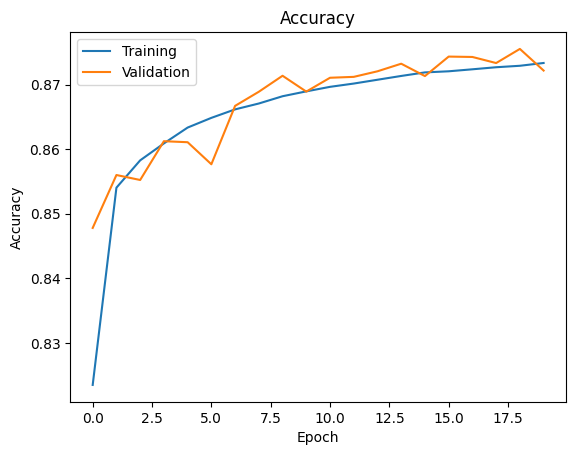

In [9]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='Training'); plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.savefig('accuracy_plot.png')